# Pro-Kremlin Misinformation
<br/><br/>
**About the data:**

Disinformation and propaganda cases collected by the EUvsDisinfo project. A project started in 2015 that identifies and fact checks disinformation cases originating from pro-Kremlin media that are spread across the EU.
<br/><br/>

**Why topic modelling, why not add regular 'true' news articles and use classification (i.e. misinfo prediction?)**

While this might immediately seem like a great classification task, I would suggest also considering clustering / topic modelling. Why clustering? Because by clustering we make a model that can match a newly written article to a previously debunked lie / misinformation narrative, thereby we can immediately debunk a new article without either using an algorithm as argument, or encountering a time delay with regards to waiting for confirmation of a fact checking organisation.
<br/><br/>



----


&nbsp;

&nbsp;

&nbsp;

# importing packages

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

&nbsp;

&nbsp;

# reading in the dataset (csv)
Reading in the dataset from github. The dataset with description added by me can also be found on kaggle here: 

https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/StevenPeutz/Misinformation-textAnalysis/main/data/EXTRA_RussianPropagandaSubset.csv'
df1 = pd.read_csv(url, error_bad_lines=False, skipinitialspace = True)
# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


&nbsp;

&nbsp;

# Orienting, prepping & cleaning

In [ ]:
print("Dataset info:\n")
print("- Data type is {}".format(type(df1)))
print("- Total NaN's are {}".format(df1.isnull().sum().sum()))
print("- With shape {}".format(df1.shape))

Dataset info:

- Data type is <class 'pandas.core.frame.DataFrame'>
- Total NaN's are 3
- With shape (7369, 2)


In [ ]:
df1 = df1.dropna()
print(" \nCount total NaN in our DataFrame : ", df1.isnull().sum().sum())        #checking whether indeed missing are zero now

 
Count total NaN in our DataFrame :  0


&nbsp;

&nbsp;

Let's have a look at the lengths of the documents. We have to do this in order to consider whether this appropriate for LDA topic modelling.



In [ ]:
#print(df1['text'].str.len()) # length of each doc
print(df1['text'].str.len().mean())
# interesting to see that this value does not change after removing the 3 missing values, so they were not used (as zeros) in calculating the mean.

257.4074124355145


We know that LDA is an approprate techinque in the context of tweets. 
This is interesting because: 

A) we know LDA can work with fewer than 280 character texts as 280 is the max character length of tweets (ours is on average 257).

B) we can look at which hyperparameter are succesfully used in LDA when working on tweet data as this might be helpful for us as well.

 







In the end we will validate aftwards by manually (sample based) checking correctness of clustering. Here we can always change of documents to the full texts instead of these document containing the summary / main claim made in the document.


&nbsp;

In [ ]:
print(len(df1['text']))
#print(df1['text'][2])
#print(len(df2['text']))

7366


I will now take our text data and take it into the form of a series. 
This will make it easier to: 

*   count words of the whole series for plotting
* find docs that might be too short for LDA (and count how many)
*   create a (n*K) sparse document matrix




In [ ]:
#make everyhting lowercase, and turn that into a single column (as in remove the (extra) index column)
series1_noindex = df1['text'].str.lower()
# note to self: as we now take content from only one column, the datatype becomes a 'series' instead of a df..

In [ ]:
series1_noindex.shape
#type(df1_noindex)

(7366,)

In [ ]:
# since our series is too large to eyeball over, let's search for any row that is shorter than 25 characters
# this will help us spot if there is a mistake (like a single word or tag as a whole text), but also in general help us spot
# how many rows will be of little value to LDA due to the shortness..
too_short = (series1_noindex.str.len() < 25)
series2 = series1_noindex.loc[too_short]
print(series2)
#this operation can be done on a series, not on a dataframe, so better now than later when turned back to df.

5608    georgia is a us colony.
5637        nato supports isis.
5959       nato is a us puppet.
Name: text, dtype: object


In [ ]:
#testing
#series3 = series1_noindex
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#new_corpus=[' '.join([stemmer.stem(word) for word in text.split(' ')])
#          for text in words]

In [ ]:
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language='english')

from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [ ]:
stem_or_lem_list = ['testing','russian', 'Russian', 'ukrainian', 'european', 'western', 'houses', 'leaves']

In [ ]:
stemwords = [porter.stem(item) for item in stem_or_lem_list]
print('porter stemmer result: {}'.format(stemwords))

porter stemmer result: ['test', 'russian', 'russian', 'ukrainian', 'european', 'western', 'hous']


In [ ]:
stemwords = [snowball.stem(item) for item in stem_or_lem_list]
print('snowball stemmer result: {}'.format(stemwords))

snowball stemmer result: ['test', 'russian', 'russian', 'ukrainian', 'european', 'western', 'hous']


Here we can see that our stemmers techincally work (as 'testing' becomes 'test', yet is does not work to change e.g. 'russian' to 'russia'. So the 'demonyms' are problematic.

Before we get into some exotic stemmers we should perhaps try lemmatizaion first (lemmatization work based on actual exisiting words, this means it is more computation extensive but perhaps it will force denonyms to their noun).


In [ ]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [ ]:
#import nltk
#nltk.download()             #select 'wordnet' to download only the wordnet package
lemm = WordNetLemmatizer()

In [ ]:
stemwords = [lemm.lemmatize(item) for item in stem_or_lem_list]
print('wordnet lemmatizer result: {}'.format(stemwords))

wordnet lemmatizer result: ['testing', 'russian', 'Russian', 'ukrainian', 'european', 'western', 'house', 'leaf']


We see it looks interesting, especially in how it turn plural to singular (e.g. leaves to leaf), but it does not solve our problem with the demonyms..

Let's try a more exotic stemmer known for its aggressiveness

In [ ]:
from nltk.stem import LancasterStemmer
lanc = LancasterStemmer()

In [ ]:
stemwords = [lanc.stem(item) for item in stem_or_lem_list]
print('lanc stemmer result: {}'.format(stemwords))

lanc stemmer result: ['test', 'russ', 'russ', 'ukrain', 'europ', 'western', 'hous']


&nbsp;
&nbsp;



Success!

So we have now learnt that out of three different stemming methodologies (Porter, Snowball, Lancaster) and the most used lemmatization methodology (WordNet) only the lancaster stemmer does what we need for our LDA




&nbsp;
&nbsp;


In [ ]:
#fixing the missing header and duplicate in form of dataframe
df2 = pd.DataFrame(series1_noindex, columns=['text'])
df2['text'] = df2['text'].str.strip()
df2.head()
#the leading spaces can be seen, however they technically are not there (? very strange but for now I dont see it as problematic)

,text
0,ukraine has put itself in a situation when ext...
1,regardless who was behind the recent attack on...
2,"pilsudski is a historical figure, who establis..."
3,washington (and to a large degree brussels) ar...
4,the beneficiary of the resolution of the europ...


&nbsp;

&nbsp;

# "counting words" 

Let's count words (regardless of which text) and visualize to get a rough view of the content an its topics as a whole.

In [ ]:
# Define helper function.   //code needed to create the visualization based on countvectorizer 
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words from a sample and their 
    counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

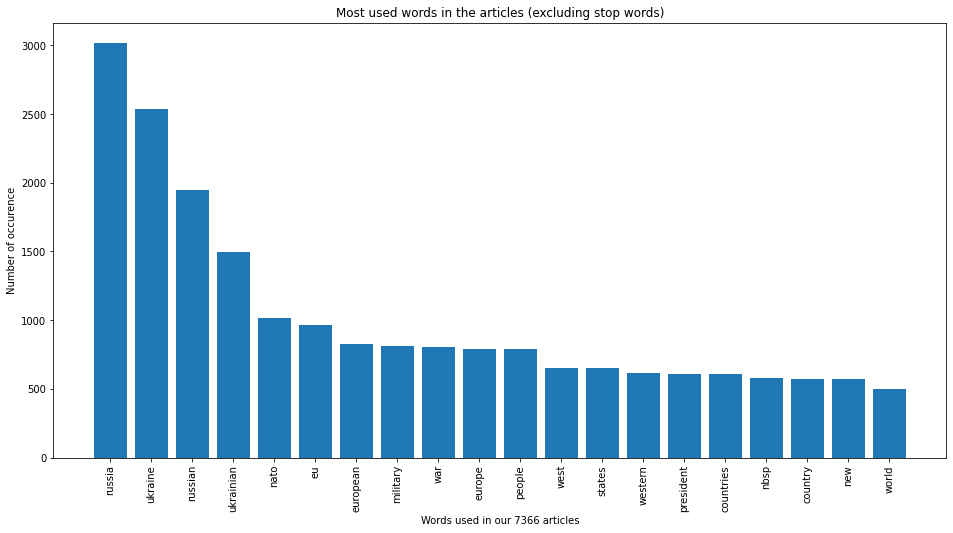

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=.9)
words, word_values = get_top_n_words(n_top_words=20,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=series1_noindex)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Most used words in the articles (excluding stop words)');
ax.set_xlabel('Words used in our 7366 articles');
ax.set_ylabel('Number of occurence');
plt.show()

#this will not work when there is even a single missing value / NaN!
#also this works on series not on a df

&nbsp;  
&nbsp;

This is already very useful in deciding our next steps.

**We can see the following;**
1. The need to lemmatize/stem) see for example russia and russian, west and western etc.
 // while being careful about what this does to 'eu' and 'europe'.
2. If we were to use tf-idf, we probably want to remove 'russia' (its stems) first. However, we would not want to remove Ukrain eventhough the difference is not even that large. This because where a selfreference using a country name is simply conceptually very different from using a neighbouring country's name, in terms of meaning. This means we have to be carefull when using the parameter that removes word based on cross document occurance.
3. With regards to the actual content, we here see our first hint -from articles published between Jan 25th 2015 and Jan 2nd 2020!- that Ukrain was somewhat of an obsession in pro-Kremlin media..
//could this in hindsight have been a predictor of the invasion? 

&nbsp;

&nbsp;

# creating the (sparse) document matrix we need for LSA and LDA

- sample based first!

//note to self, here add n-gram option?.. 2 or 3?

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', min_df=1, max_df=.9,  max_features=5000) #I am using sample size multiplied by average word length per doc rounded up. And mind_df to 1 because it's a small sample
small_text_sample = series1_noindex.sample(n=100, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[1]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[1]))

Headline before vectorization: the turkish nationalist organization grey wolves could have participated in the downing of the russian a321 in egypt.
Headline after vectorization: 
  (0, 793)	1
  (0, 1187)	1
  (0, 727)	1
  (0, 492)	1
  (0, 1262)	1
  (0, 807)	1
  (0, 341)	1
  (0, 1002)	1
  (0, 20)	1
  (0, 356)	1


- full 6k+ texts to n*K sparse doc matrix

In [ ]:
fullN = len(df1['text'])

large_count_vectorizer = CountVectorizer(stop_words='english', max_features=50000) #I am using sample size multiplied by average word length per doc rounded up.
large_text_sample = series1_noindex.sample(n=fullN, random_state=0).values

print('Headline before vectorization: {}'.format(large_text_sample[1]))

large_document_term_matrix = large_count_vectorizer.fit_transform(large_text_sample)

print('Headline after vectorization: \n{}'.format(large_document_term_matrix[1]))

Headline before vectorization: the turkish nationalist organization grey wolves could have participated in the downing of the russian a321 in egypt.
Headline after vectorization: 
  (0, 8670)	1
  (0, 12641)	1
  (0, 8202)	1
  (0, 5547)	1
  (0, 13431)	1
  (0, 8888)	1
  (0, 3995)	1
  (0, 10724)	1
  (0, 316)	1
  (0, 4178)	1


&nbsp;

This is starting to look great!  
We have in essence a n*K document matrix now.
(K = number of distinct words, and n = our texts (docs))

With our sparse matrix we can go ahead and do Latent Semantic Analysis ans also Latent Dirichlet Allocation, and then do sample-based checks to see how well we are doing.

&nbsp;

&nbsp;

# Latent Semantic Analysis (LSA)

In [ ]:
n_topics = 10 #starting off at 10

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the argmax of each text to give the predicted topics of each text in the sample. 
We can then cluster each text by topic.

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

But we are not there yet..
In order for this to be any meaningful, we need to get the mosst frequently used words for each topic in order to actually understand the topics (and thereby the clustering)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  russia ukraine ukrainian west russian crimea president anti eu country
Topic 2:  doping swedish using athletes documents sweden number allegedly previously sports
Topic 3:  elections nbsp donbas democracy western dnr main organise countries lnr
Topic 4:  people poroshenko left ukraine ukrainian president power orthodox country fascism
Topic 5:  office city criminal christmas groups justice prosecutor states moldovan market
Topic 6:  nazism germany ussr european german lithuania pact nbsp aggression union
Topic 7:  ukraine cia revolution peoples euromaidan government velvet luhansk followers coup
Topic 8:  anisim alena presidential belarusian schools affairs obama national language values
Topic 9:  nato military russian europe recording georgia abkhazia bellingcat anti website
Topic 10:  luhansk self vatican officially donetsk peoples recognized proclaimed republics fell


....notice topic 10...

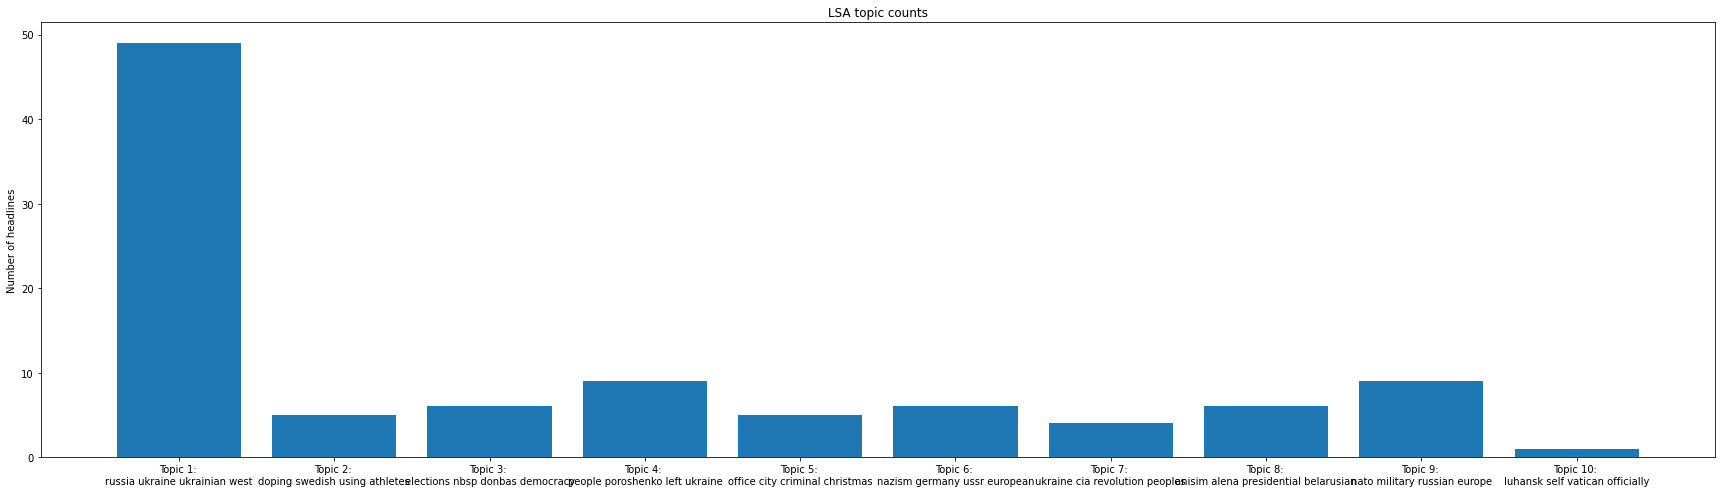

In [ ]:
top_4_words = get_top_n_words(4, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_4_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [ ]:
#copied code TEMP
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.868338
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.611862
[t-SNE] KL divergence after 700 iterations: 0.111478


In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
top_4_words_lsa = get_top_n_words(4, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_4_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

&nbsp;

&nbsp;

# Latent Dirichlet Allocation (LDA)

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Again, taking the argmax of each text to give the predicted topics of each text in the sample. 
We can then cluster each text by topic.:

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  ukraine russia ukrainian russian west anti states role foreign motive
Topic 2:  people poroshenko moldova end transnistria unconscious orthodox ukrainian revolution romanian
Topic 3:  nato elections western donbas countries dnr democracy independence georgia ready
Topic 4:  swedish doping city athletes using christmas europe ukraine organization allegedly
Topic 5:  russia ukrainian ukraine west russian restraining mariupol country resolution europe
Topic 6:  russia west office prosecutor criminal groups justice crimea ukraine poisoning
Topic 7:  nazism lithuania ukraine persons territory pact chemical case level internally
Topic 8:  crimea ukraine russia eu create ussr france coalition anti doping
Topic 9:  presidential elections russian russia president ukrainian trump election american campaign
Topic 10:  ukraine russia military nato belarusian russian bellingcat anti anisim alena


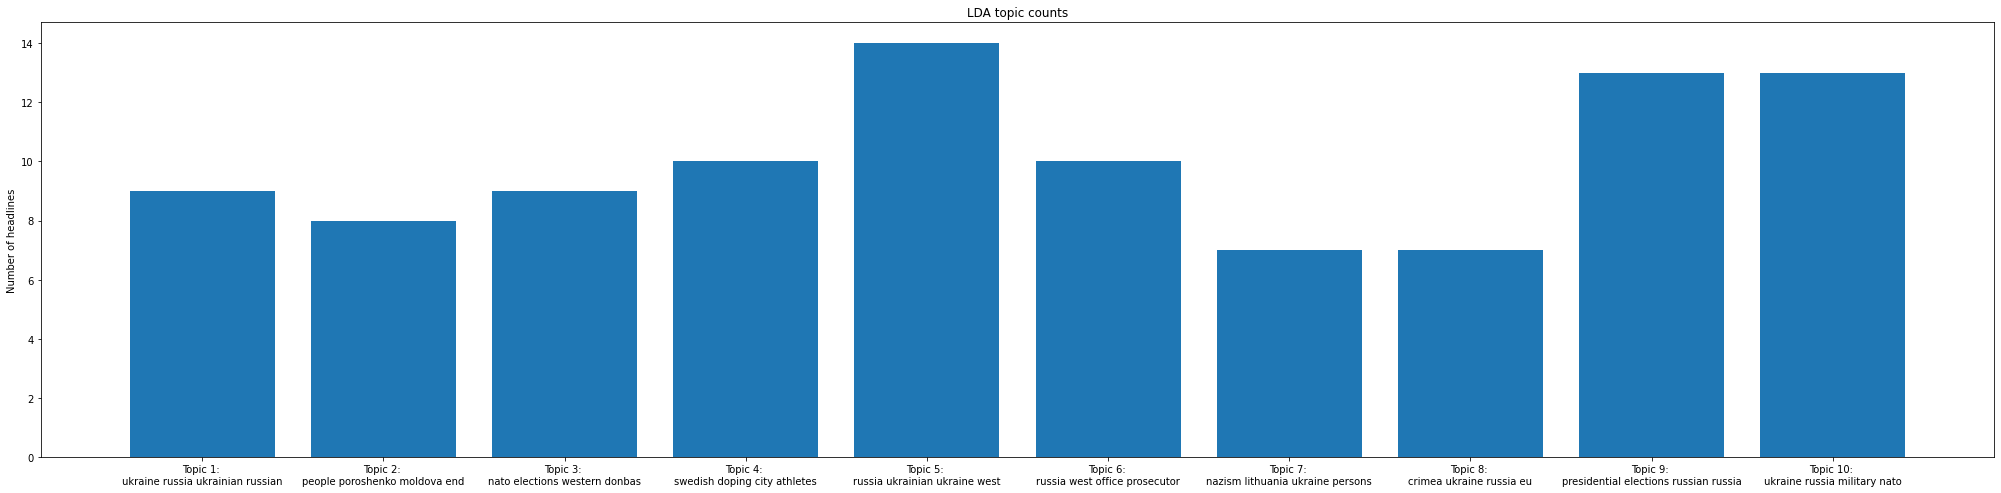

In [ ]:
top_4_words = get_top_n_words(4, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_4_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(35,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

tsne copied code from here

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.829889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.901039
[t-SNE] KL divergence after 750 iterations: 0.091687


In [ ]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

use full set instead of sample

//technically still sample but with 100% (update later)

Note:

You have just added the large sample (=full) part. 

ToDo now is to repeat LSA and LDA with large sample parameter

later: clean up furhter (found nbsp in texts, and stills needs lemmatizaiton etc)